Monitoring Penyebaran Covid 19 pada Area Publik dengan Convolution Neural Networks (CNN)

## SK6093-Independent Research in Computational Science 3 :
## Sistem Deteksi Masker Wajah pada Area Publik Menggunakan Convolution Neural Networks
Oleh: Ade Lailani (20920003)


### Abstrak
Pada RBL kali ini kami akan membuat model pendeteksi masker dengan Convolutional Neural Network.
Adapun tujuan dalam penelitian adalah untuk mengklasifikasikan foto wajah yang akan kita bagi datanya menjadi dua kelas, sehingga kita dapat menjawab pertanyaan berikut.

Apakah orang itu memakai masker atau tidak?

Sistem deteksi masker (Face mask detection) dengan menggunakan pengolahan citra dilakukan juga untuk mengetahui besar akurasi dari metode Convolution Neural Networks (CNN) yang digunakan.

### Langkah 1 : Pengumpulan Data

Dataset : https://www.kaggle.com/omkargurav/face-mask-dataset

Dataset berukuran 160 MB, berisi 7553 foto dengan 3-channel jpg extension (RGB). Dataset tersebut terdiri dari 3725 foto wajah dengan masker dan 3828 foto wajah tanpa masker dengan berbagai ukuran foto.

### Langkah 2 : Split Data

In [2]:
import os
import shutil

# mengakses dataset awal
data_dir = 'data'

# membuat informasi class
all_class = {'train':{},'valid':{}}
for cl in os.listdir(data_dir):
    items = os.listdir(f'{data_dir}/{cl}')
    test_count = int(0.2*(len(items)))
    all_class['train'][cl] = items[test_count:]
    all_class['valid'][cl] = items[:test_count]

In [3]:
# memindahkan file dataset awal ke folder baru 
for category,cl in all_class.items():
    for sub_class,item in cl.items():
        for i in item:
            print(f'{category}/{sub_class}/{i}')
            des_path = f'dataset/{category}/{sub_class}/'
            os.makedirs(des_path, exist_ok=True)
            shutil.move(f'{data_dir}/{sub_class}/{i}',des_path)

Selanjutnya, kita perlu mengimpor semua pustaka yang diperlukan.

Definisikan loading_data()fungsi untuk mengulang direktori untuk memasukkan semua direktori file ke dalam daftar python.

In [4]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
keras = tf.keras

In [5]:
def loading_data():
    dirname = 'dataset/'
    dirtype = ['train/', 'valid/']
    dirclass = ['with_mask/', 'without_mask/']
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    for typ in dirtype:
        for cls in dirclass:
            for i in os.listdir(dirname+typ+cls):
                if typ == 'train/':
                    x_train.append(dirname+'train/'+cls+i)
                    y_train.append(cls[:-1])
                else:
                    x_test.append(dirname+'valid/'+cls+i)
                    y_test.append(cls[:-1])
    return np.array(x_train),np.array(y_train),np.array(x_test),np.array(y_test)


# Run loading_data() function
x_train,y_train,x_test,y_test = loading_data()

mengekstrak file zip, Refactor direktori menjadi terlihat seperti ini.
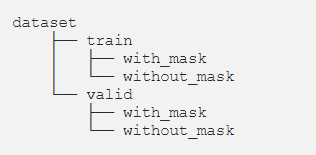


### Langkah 3 : Data Preprocessing

untuk meningkatkan kinerja model dan menghindari overfitting dapat dilakukan flipping, rotating, cropping, zooming, and shifting the image position.

Karena gambar kita memilki ukuran yang berbeda beda maka kita resize
setiap gambar menjadi 224x224

kami menggunakan input output Tensorflow tf.io.read_file(path) karena kami ingin membuat batch data sebelum melatih model, sehingga proses pelatihan dapat berjalan lebih cepat.

In [6]:
# Processing image files into numpy array
def process_label(label):
    label = [i == unique_label for i in label]
    label = np.array(label).astype(int)
    return label
  
def processImage(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image,size=[224,224])
    return image

# Create Batch data of numpy array
def pairData(image,label):
    return processImage(image),label
  
def batchData(image,label=None,for_valid=False,for_test=False):
    if for_test:
        data = tf.data.Dataset.from_tensor_slices((image))
        batch = data.map(processImage).batch(32)
        return batch
    elif for_valid:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(image),tf.constant(label)))
        batch = data.map(pairData).batch(32)
        return batch
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(image),tf.constant(label)))
        data = data.shuffle(buffer_size=len(image))
        batch = data.map(pairData).batch(32)
        return batch
  
unique_label = np.unique(y_test)
y_test = process_label(y_test)
y_train = process_label(y_train)

train_data = batchData(x_train,y_train)
valid_data = batchData(x_test,y_test,for_valid=True)

In [7]:
x_train,y_train,x_test,y_test = loading_data()

In [8]:
x_train,x_test

(array(['dataset/train/with_mask/with_mask_1557.jpg',
        'dataset/train/with_mask/with_mask_1558.jpg',
        'dataset/train/with_mask/with_mask_1559.jpg', ...,
        'dataset/train/without_mask/without_mask_997.jpg',
        'dataset/train/without_mask/without_mask_998.jpg',
        'dataset/train/without_mask/without_mask_999.jpg'], dtype='<U48'),
 array(['dataset/valid/with_mask/with_mask_1.jpg',
        'dataset/valid/with_mask/with_mask_10.jpg',
        'dataset/valid/with_mask/with_mask_100.jpg',
        'dataset/valid/with_mask/with_mask_1000.jpg',
        'dataset/valid/with_mask/with_mask_1001.jpg',
        'dataset/valid/with_mask/with_mask_1002.jpg',
        'dataset/valid/with_mask/with_mask_1003.jpg',
        'dataset/valid/with_mask/with_mask_1004.jpg',
        'dataset/valid/with_mask/with_mask_1005.jpg',
        'dataset/valid/with_mask/with_mask_1006.jpg',
        'dataset/valid/with_mask/with_mask_1007.jpg',
        'dataset/valid/with_mask/with_mask_1008.jpg'

In [9]:
y_train,y_test

(array(['with_mask', 'with_mask', 'with_mask', ..., 'without_mask',
        'without_mask', 'without_mask'], dtype='<U12'),
 array(['with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
        'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
        'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
        'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
        'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
        'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
        'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
        'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
        'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
        'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
        'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
        'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',


### Langkah 4 : Membangun Neural Network


kami membuat Convoutional Neural Network (CNN) dengan Keras. Disini kami menggunakan 2 unit Dense layer  dengan aktivasi Softmax sebagai node keluaran karena kami ingin 2 buah keluaran array agar lebih mudah menerima informasi yang diprediksi.

In [10]:
# Create model structure
model = keras.Sequential([
    # Input Layer
    keras.layers.Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(),
    
    # Hidden Layer
    keras.layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(input_shape=(224,224,3),filters=128,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128),
    keras.layers.Activation('relu'),
    
    # Output Layer
    keras.layers.Dense(2),
    keras.layers.Activation('sigmoid')
])

# Compile model
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(),metrics=['acc'])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

### Langkah 5: Model Pelatihan

Proses pelatihan berjalan selama 50 epoch. kami juga menggunakan penghentian awal agar proses pelatihan dapat dihentikan secara otomatis jika model tidak membaik selama 3 epcoh. Ini juga digunakan untuk menghindari overfitting.

Epoch 1/50
212/212 [==============================] - 246s 1s/step - loss: 0.6965 - acc: 0.4572 - val_loss: 0.6931 - val_acc: 0.8021
Epoch 2/50
212/212 [==============================] - 238s 1s/step - loss: 0.6931 - acc: 0.4580 - val_loss: 0.6931 - val_acc: 0.8021
Epoch 3/50
212/212 [==============================] - 230s 1s/step - loss: 0.6931 - acc: 0.4580 - val_loss: 0.6931 - val_acc: 0.8021
Epoch 4/50
212/212 [==============================] - 221s 1s/step - loss: 0.6931 - acc: 0.4580 - val_loss: 0.6931 - val_acc: 0.8021


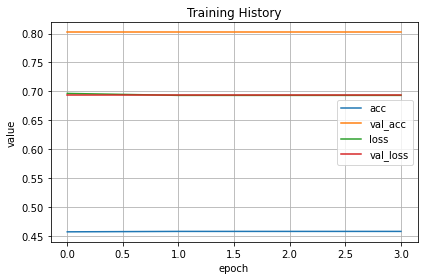

In [12]:
# buat panggilan balik penghentian awal
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

# Simpan riwayat model menjadi variabel
history = model.fit(train_data,validation_data = valid_data,validation_freq=1,epochs = 50,callbacks = [early_stopping],verbose = 1,)

# Plot model training history
def plot_history():
    plt.plot(history.history['acc'],label='acc')
    plt.plot(history.history['val_acc'],label='val_acc')
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.legend()
    plt.title('Training History')
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.tight_layout()
    plt.grid(True)
    plt.savefig('output/training_history-sigmoid-adam.jpg')
    plt.show()

plot_history()

In [14]:
import pandas as pd
df =pd.DataFrame.from_dict(history.history)
print(df.mean())


loss        0.693988
acc         0.457780
val_loss    0.693147
val_acc     0.802070
dtype: float64


### Langkah 6: Demonstrasi

kami melakukan demonstrasi menggunakan 12 foto. berikut hasil model yang dapat memprediksi dengan nilai probabilitas tertentu.

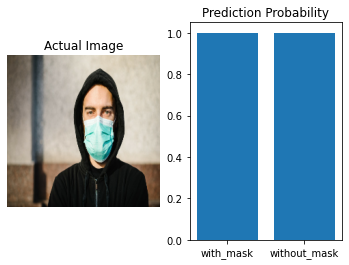

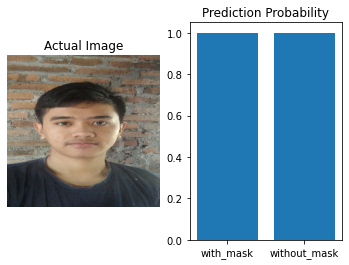

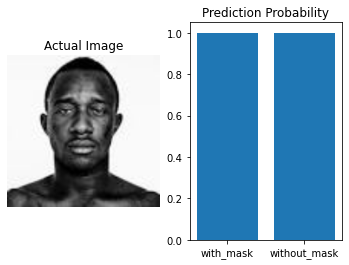

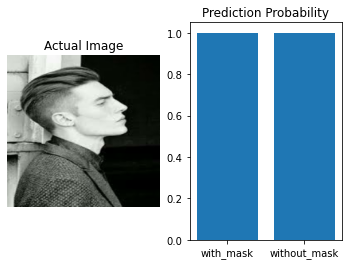

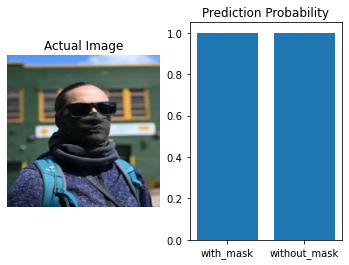

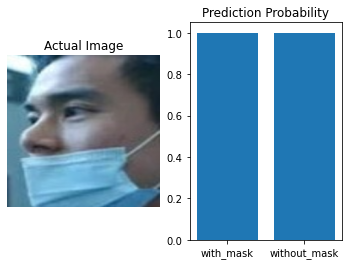

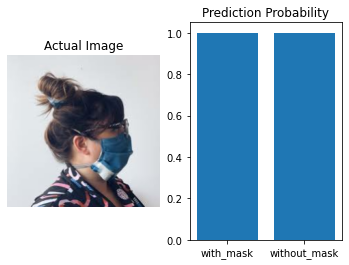

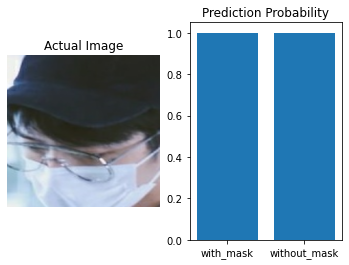

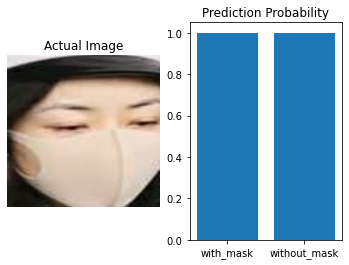

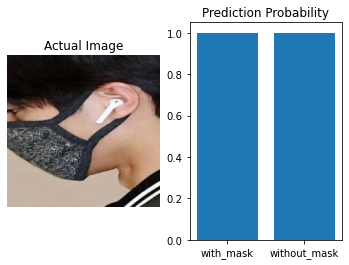

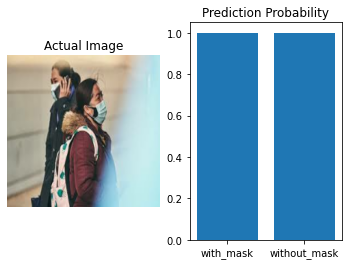

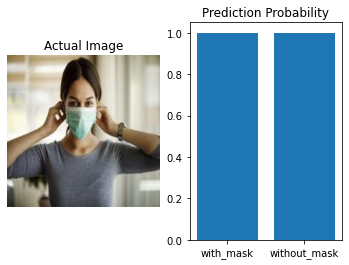

In [15]:
def predict(unseen_image = []):
    test_data = batchData(unseen_image,for_test=True)
    prediction = model.predict(test_data)

    for image,pred in zip(unseen_image,prediction):
        fig,axes = plt.subplots(nrows=1,ncols=2)
        axes[0].imshow(processImage(image))
        axes[0].axis(False)
        axes[0].set_title('Actual Image')

        axes[1].bar([0,1],pred)
        axes[1].set_xticks([0,1])
        axes[1].set_xticklabels(['with_mask','without_mask'])
        axes[1].set_title('Prediction Probability')
        plt.savefig(f'output/prediction_test_{image.split("/")[-1].split(".")[0]}.jpg')
        plt.show()
                    
predict(list(map(lambda x : f'test/{x}', os.listdir('test'))))

In [19]:
TP = 12
TN = 0
F = 12
(TP+TN)/(TP+TN+F)*100

50.0

menyimpan model ke dalam file h5

In [17]:
model.save('output/face_mask_ai.h5')

#### Parameter yang akan di analisis
variasi aktivasi : relu-relu-softmax, relu-relu-sigmoid

variasi optimizer :  Adam dan AdaDelta, 
